In [175]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [176]:
import pandas as pd

df = pd.read_csv("gender-classifier-DFE-791531.csv", encoding='cp1251')

df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,‰ЫПIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN


In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _golden                20050 non-null  bool   
 2   _unit_state            20050 non-null  object 
 3   _trusted_judgments     20050 non-null  int64  
 4   _last_judgment_at      20000 non-null  object 
 5   gender                 19953 non-null  object 
 6   gender:confidence      20024 non-null  float64
 7   profile_yn             20050 non-null  object 
 8   profile_yn:confidence  20050 non-null  float64
 9   created                20050 non-null  object 
 10  description            16306 non-null  object 
 11  fav_number             20050 non-null  int64  
 12  gender_gold            50 non-null     object 
 13  link_color             20050 non-null  object 
 14  name                   20050 non-null  object 
 15  pr

In [178]:
df.isna().sum()

_unit_id                     0
_golden                      0
_unit_state                  0
_trusted_judgments           0
_last_judgment_at           50
gender                      97
gender:confidence           26
profile_yn                   0
profile_yn:confidence        0
created                      0
description               3744
fav_number                   0
gender_gold              20000
link_color                   0
name                         0
profile_yn_gold          20000
profileimage                 0
retweet_count                0
sidebar_color                0
text                         0
tweet_coord              19891
tweet_count                  0
tweet_created                0
tweet_id                     0
tweet_location            7484
user_timezone             7798
dtype: int64

Столбец profile_yn_gold получается из столбцов _golden и profile_yn, поэтому сам по себе не имеет практической ценности (аналогично с gender_gold)

Столбец tweet_coord в силу крайне малой заполненности бесполезен

In [179]:
df = df.drop(columns = ['profile_yn_gold', 'gender_gold', 'tweet_coord'])

Столбец describtion можно удалить, так как он содержит текст (описание профилей), который невозможно обработать для логической регрессии.
Столбцы tweet_location и user_timezone мало смогут повлиять на классификацию по полу, поэтому также могут быть удалены.

In [180]:
df = df.drop(columns = ['description', 'tweet_location', 'user_timezone'])

Пользователей с пропусками в столбцах gender:confidence и _last_judgment_at можно удалить из-за незначительности их количества по сревнению с общей суммой пользователей
Столбец gender является ключевым для составления логической регрессии, поэтому пользователей с пропусками в этом столбце тоже придётся удалить

In [181]:
df = df.dropna(axis=0, how='any')

In [182]:
df.isna().sum()

_unit_id                 0
_golden                  0
_unit_state              0
_trusted_judgments       0
_last_judgment_at        0
gender                   0
gender:confidence        0
profile_yn               0
profile_yn:confidence    0
created                  0
fav_number               0
link_color               0
name                     0
profileimage             0
retweet_count            0
sidebar_color            0
text                     0
tweet_count              0
tweet_created            0
tweet_id                 0
dtype: int64

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19903 entries, 0 to 19999
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               19903 non-null  int64  
 1   _golden                19903 non-null  bool   
 2   _unit_state            19903 non-null  object 
 3   _trusted_judgments     19903 non-null  int64  
 4   _last_judgment_at      19903 non-null  object 
 5   gender                 19903 non-null  object 
 6   gender:confidence      19903 non-null  float64
 7   profile_yn             19903 non-null  object 
 8   profile_yn:confidence  19903 non-null  float64
 9   created                19903 non-null  object 
 10  fav_number             19903 non-null  int64  
 11  link_color             19903 non-null  object 
 12  name                   19903 non-null  object 
 13  profileimage           19903 non-null  object 
 14  retweet_count          19903 non-null  int64  
 15  si

Удалим или преобразуем столбцы с типами object и bool

In [184]:
df['_unit_state'].unique()

array(['finalized'], dtype=object)

Этот столбец можно удалить

In [185]:
df = df.drop(columns = ['_unit_state'])

In [186]:
df['_last_judgment_at']

0        10/26/15 23:24
1        10/26/15 23:30
2        10/26/15 23:33
3        10/26/15 23:10
4         10/27/15 1:15
              ...      
19995    10/26/15 23:04
19996     10/27/15 1:40
19997     10/27/15 0:03
19998    10/26/15 22:27
19999    10/26/15 22:09
Name: _last_judgment_at, Length: 19903, dtype: object

Для линейной регрессии этот столбец бесполезен, удаляем

In [187]:
df = df.drop(columns = ['_last_judgment_at'])

In [188]:
df['profile_yn'].unique()

array(['yes'], dtype=object)

Не влияет ни на что, удаляем

In [189]:
df = df.drop(columns = ['profile_yn'])

In [190]:
df['created']

0          12/5/13 1:48
1         10/1/12 13:51
2        11/28/14 11:30
3         6/11/09 22:39
4         4/16/14 13:23
              ...      
19995     1/24/13 11:55
19996    12/19/14 13:54
19997     4/15/15 19:15
19998      4/6/15 13:43
19999      4/6/09 16:54
Name: created, Length: 19903, dtype: object

Для регрессии бесполезен, удаляем

In [191]:
df = df.drop(columns = ['created'])

In [192]:
df['link_color']

0        08C2C2
1        0084B4
2        ABB8C2
3        0084B4
4        3B94D9
          ...  
19995    ABB8C2
19996    0084B4
19997    664422
19998    05B8CC
19999    0084B4
Name: link_color, Length: 19903, dtype: object

Не является категориальной переменной и не подлежит обработке, удаляем

In [193]:
df = df.drop(columns = ['link_color'])

In [194]:
df['name']

0                sheezy0
1            DavdBurnett
2         lwtprettylaugh
3            douggarland
4           WilfordGemma
              ...       
19995         AntiHero94
19996           dredoo24
19997    6BETHANY4Victor
19998     SorasNerdyGeek
19999         Gbuschrist
Name: name, Length: 19903, dtype: object

Не подлежит обработке и в целом бесполезно, удаляем

In [195]:
df = df.drop(columns = ['name'])

In [196]:
df['profileimage']

0        https://pbs.twimg.com/profile_images/414342229...
1        https://pbs.twimg.com/profile_images/539604221...
2        https://pbs.twimg.com/profile_images/657330418...
3        https://pbs.twimg.com/profile_images/259703936...
4        https://pbs.twimg.com/profile_images/564094871...
                               ...                        
19995    https://pbs.twimg.com/profile_images/653014313...
19996    https://pbs.twimg.com/profile_images/633240548...
19997    https://pbs.twimg.com/profile_images/657192653...
19998    https://pbs.twimg.com/profile_images/656988985...
19999    https://pbs.twimg.com/profile_images/601763980...
Name: profileimage, Length: 19903, dtype: object

Обработка невозможна, удаляем

In [197]:
df = df.drop(columns = ['profileimage'])

In [198]:
df['sidebar_color'].unique()

array(['FFFFFF', 'C0DEED', '0', '181A1E', 'EEEEEE', '65B0DA', 'EEA525',
       'DBE9ED', 'BDDCAD', 'C6E2EE', 'F2E195', 'DFDFDF', '80808',
       'D9B17E', '5ED4DC', 'FFF8AD', '87BC44', 'E59B38', '829D5E',
       'D10707', 'CC3366', '0A0A0A', '515', '30303', 'A8C7F7', '035FFF',
       '22261', 'E5FFA6', 'ADF1FC', '69E2E8', 'F8F132', 'D3D2CF',
       'FCFBD2', '2280A9', '50505', 'F8C7DA', '64533E', '827D82',
       '6B0237', 'A38CA3', 'F7F2F4', '487878', '151F24', 'AD1F74',
       'FFDE00', '79B6E7', '0AB0F1', '12020F', '86A4A6', '3FC5A4',
       '2E0C2E', 'C0DCF1', '3BE0F4', '0066FF', '8CBAE2', '08A7F7',
       '7C6A87', '8BB65D', '89B5A2', 'CCCCCC', '6A6B69', '0E4766',
       'D6BD89', 'EB63EB', 'BA7474', '0D0C0C', 'FAA005', '16818E',
       'F50C0C', 'A310A3', 'FF0D3D', '6056', 'F8545F', 'FF08FF', 'B5B5B5',
       '141414', '292929', '4BB7DF', 'A3A3A3', 'DADADA', 'FCF3B8',
       '999999', '131414', 'FFCE0A', '42444E', '212535', 'D179CB',
       '5C0F5C', 'E6D56A', 'ED2B45', '5C005C',

Не является категориальной переменной и не подлежит обработке, удаляем

In [199]:
df = df.drop(columns = ['sidebar_color'])

In [200]:
df["text"]

0        Robbie E Responds To Critics After Win Against...
1        ‰ЫПIt felt like they were my friends and I was...
2        i absolutely adore when louis starts the songs...
3        Hi @JordanSpieth - Looking at the url - do you...
4        Watching Neighbours on Sky+ catching up with t...
                               ...                        
19995    Seriously love Trent and Justin. Would do anyt...
19996    One person can look at you like your the most ...
19997    These 24 Wedding Photobombs Made The Bride And...
19998    So I am riding around and I saw a horse runnin...
19999    @toddrose24 @sadsackjetsfan yes I'd call that ...
Name: text, Length: 19903, dtype: object

Не обрабатываемо, удаляем

In [201]:
df = df.drop(columns = ['text'])

In [202]:
df['tweet_created']

0        10/26/15 12:40
1        10/26/15 12:40
2        10/26/15 12:40
3        10/26/15 12:40
4        10/26/15 12:40
              ...      
19995    10/26/15 13:18
19996    10/26/15 13:18
19997    10/26/15 13:18
19998    10/26/15 13:18
19999    10/26/15 13:18
Name: tweet_created, Length: 19903, dtype: object

Бесполезно, удаляем

In [203]:
df = df.drop(columns = ['tweet_created'])

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19903 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               19903 non-null  int64  
 1   _golden                19903 non-null  bool   
 2   _trusted_judgments     19903 non-null  int64  
 3   gender                 19903 non-null  object 
 4   gender:confidence      19903 non-null  float64
 5   profile_yn:confidence  19903 non-null  float64
 6   fav_number             19903 non-null  int64  
 7   retweet_count          19903 non-null  int64  
 8   tweet_count            19903 non-null  int64  
 9   tweet_id               19903 non-null  float64
dtypes: bool(1), float64(3), int64(5), object(1)
memory usage: 1.5+ MB


In [205]:
df['_trusted_judgments'].unique()

array([3])

Бесполезно, удаляем

In [206]:
df = df.drop(columns = ['_trusted_judgments'])

In [207]:
df['_golden'].unique()

array([False])

В результате обработки в столбе _golden осталось единственное значение, удалим этот столбец

In [208]:
df = df.drop(columns = ['_golden'])

Параметр gender является категориальными, поэтому обработаем его

In [209]:
df['gender'].unique()

array(['male', 'female', 'brand', 'unknown'], dtype=object)

In [220]:
df = df[(df['gender'] == 'male') | (df['gender'] == 'female')]

In [221]:
df['gender'].unique()

array(['male', 'female'], dtype=object)

In [222]:
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder() 
encoder.fit(df['gender']) 
df['gender'] = encoder.transform(df['gender']) 

df.head()

,_unit_id,gender,gender:confidence,profile_yn:confidence,fav_number,retweet_count,tweet_count,tweet_id
0,815719226,1,1.0000,1.0,0,0,110964,6.587300e+17
1,815719227,1,1.0000,1.0,68,0,7471,6.587300e+17
2,815719228,1,0.6625,1.0,7696,1,5617,6.587300e+17
3,815719229,1,1.0000,1.0,202,0,1693,6.587300e+17
4,815719230,0,1.0000,1.0,37318,0,31462,6.587300e+17


(Я столько времени убил только на обработку данных...)

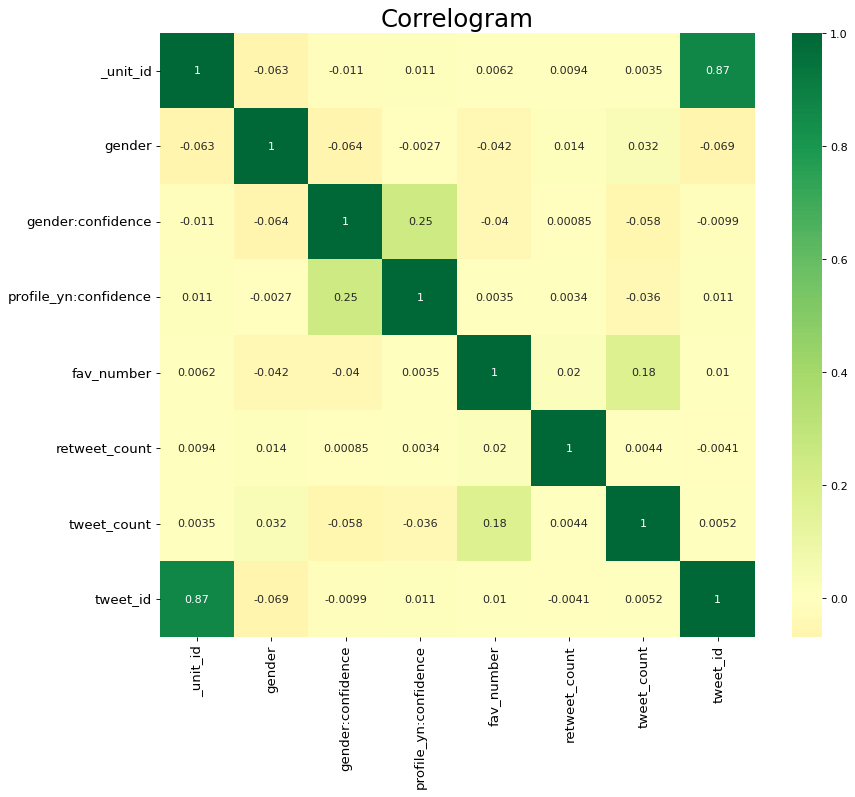

In [223]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Correlogram', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Признаки практически не коррелируют между собой

Столбцы tweet_id и _unit_id бесполезны для логической регрессии, удалим

In [224]:
df = df.drop(columns = ['_unit_id', 'tweet_id'])

Создадим модель логической регрессии

In [225]:
from sklearn.model_selection import train_test_split

X = df.drop(['gender'], axis=1)
y = df['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [226]:
from sklearn.linear_model import LogisticRegression

In [227]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [231]:
answers_pred = model.predict(X_test)

In [228]:
print(X_train.shape)
print(y_train.size)

(9000, 5)
9000


In [229]:
w0 = model.intercept_
w0

array([-1.49643366e-09])

In [230]:
w1 = model.coef_
w1

array([[-1.98782060e-09, -1.49664058e-09, -7.44029357e-06,
         8.51091682e-10,  7.33325878e-07]])

Наибольший вес имеет признак fav_number, после него идёт tweet_count, вызвано это тем, что признак gender коррелирует больше всего именно с этими двумя признаками

In [235]:
eq = "Y = " + str(w0)
for i in range(X.shape[1]):
  eq += " + (" + str(w1[0][i]) + ")*X" + str(i)
print("Уравнение логической регрессии: ", eq)

Уравнение логической регрессии:  Y = [-1.49643366e-09] + (-1.9878205993000253e-09)*X0 + (-1.496640577407202e-09)*X1 + (-7.440293570738918e-06)*X2 + (8.510916817071807e-10)*X3 + (7.333258782494976e-07)*X4


Выведем confusion matrix

In [236]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

confusion_matrix(y_test, answers_pred)

array([[1327,  695],
       [1027,  809]])

In [245]:
tp = 1327
fp = 695
fn = 1027
tn = 809
print("accuracy:", (tp + tn)/(tp+fp+fn+tn))
rc = tp / (tp+fn)
pr = tp / (tp+fp)
print("recall:", rc)
print("precision:", pr)
print("f1:", 2*(rc*pr)/(rc+pr))

accuracy: 0.5536547433903577
recall: 0.5637213254035683
precision: 0.6562809099901088
f1: 0.606489945155393


In [243]:
print("accuracy:",accuracy_score(y_test, answers_pred))
print("recall:",recall_score(y_test, answers_pred))
print("precision:",precision_score(y_test, answers_pred))
print("f1:",f1_score(y_test, answers_pred))

accuracy: 0.5536547433903577
recall: 0.4406318082788671
precision: 0.5378989361702128
f1: 0.48443113772455093


Вывод: sklearn показывает всё более плачевным

В данном случае модель логической регрессии получилась на очень точной из-за того, что при обработке было отброшено огромное количество данных (таких как имя, описание прифиля и изображение профиля) из-за невозможности их обработки. Также стоит отметить, что количество лайков, ретвитов и твитов плохо репрезентует пол человека